#RESUME -  JOB MATCHER

Load required libraries

In [2]:
!pip install pandas scikit-learn nltk

import pandas as pd
import numpy as np
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import string

Mount Drive

In [4]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load datasets

In [5]:
# load resume csv dataset

df1 = pd.read_csv("/content/drive/MyDrive/Resume.csv")
print(df1.head())

         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  


In [6]:
# load job description csv dataset

df2 = pd.read_csv("/content/drive/MyDrive/JobsDataset.csv")
print(df2.head())

   ID           Query                             Job Title  \
0   1  Data Scientist  Junior Data Scientist Apprenticeship   
1   2  Data Scientist   HBO Data Scientist, Content Science   
2   3  Data Scientist                 Junior Data Scientist   
3   4  Data Scientist                     Jr Data Scientist   
4   5  Data Scientist       Data Scientist, Premium Content   

                                         Description  
0  Job Description As a Junior Data Scientist at ...  
1  OVERALL SUMMARY As a Data Scientist on the Dat...  
2  The Team: The Data science team is a newly for...  
3  We now have a need for junior Data Scientist(s...  
4  Do you want to help guide the core business of...  


Preprocess both datasets

In [7]:
# preprocess

from nltk.stem import WordNetLemmatizer

# Download resources

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [8]:
def preprocess_resume_text(text: str) -> str:
    """
    Clean plain text resumes for ML/NLP analysis.
    """

    # 1. Lowercase
    text = text.lower()

    # 2. Remove digits and punctuation
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 3. Tokenize
    tokens = nltk.word_tokenize(text)

    # 4. Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # 5. Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # 6. Return cleaned string
    return " ".join(tokens)

In [9]:
# Drop unnecessary HTML column
df1 = df1.drop(columns=["Resume_html"])

# Clean the resume text
df1["cleaned_resume"] = df1["Resume_str"].apply(preprocess_resume_text)

# preview
df1[["Category", "cleaned_resume"]].head()

,Category,cleaned_resume
0,HR,administratormarketing associate administrator...
1,HR,specialist operation summary versatile medium ...
2,HR,director summary year experience recruiting pl...
3,HR,specialist summary dedicated driven dynamic ye...
4,HR,manager skill highlight skill department start...


In [10]:
# Preprocess description column
df2["cleaned_description"] = df2["Description"].apply(preprocess_resume_text)

# preview
df2[["Job Title", "cleaned_description"]].head()

,Job Title,cleaned_description
0,Junior Data Scientist Apprenticeship,job description junior data scientist ibm work...
1,"HBO Data Scientist, Content Science",overall summary data scientist data science so...
2,Junior Data Scientist,team data science team newly formed applied re...
3,Jr Data Scientist,need junior data scientist area remote success...
4,"Data Scientist, Premium Content",want help guide core business spotify using in...


In [11]:
df1 = df1[df1["cleaned_resume"].str.strip() != ""]
df2 = df2[df2["cleaned_description"].str.strip() != ""]

In [12]:
def truncate_words(text, max_words=300):
    return " ".join(text.split()[:max_words])

df1["cleaned_resume"] = df1["cleaned_resume"].apply(truncate_words)
df2["cleaned_description"] = df2["cleaned_description"].apply(truncate_words)


In [13]:
df1

,ID,Resume_str,Category,cleaned_resume
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,administratormarketing associate administrator...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,specialist operation summary versatile medium ...
2,33176873,HR DIRECTOR Summary Over 2...,HR,director summary year experience recruiting pl...
3,27018550,HR SPECIALIST Summary Dedica...,HR,specialist summary dedicated driven dynamic ye...
4,17812897,HR MANAGER Skill Highlights ...,HR,manager skill highlight skill department start...
...,...,...,...,...
2479,99416532,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,AVIATION,rank sgte non commissioned officer charge brig...
2480,24589765,"GOVERNMENT RELATIONS, COMMUNICATIONS ...",AVIATION,government relation communication organization...
2481,31605080,GEEK SQUAD AGENT Professional...,AVIATION,geek squad agent professional profile support ...
2482,21190805,PROGRAM DIRECTOR / OFFICE MANAGER ...,AVIATION,program director office manager summary highly...


In [14]:
df2

,ID,Query,Job Title,Description,cleaned_description
0,1,Data Scientist,Junior Data Scientist Apprenticeship,Job Description As a Junior Data Scientist at ...,job description junior data scientist ibm work...
1,2,Data Scientist,"HBO Data Scientist, Content Science",OVERALL SUMMARY As a Data Scientist on the Dat...,overall summary data scientist data science so...
2,3,Data Scientist,Junior Data Scientist,The Team: The Data science team is a newly for...,team data science team newly formed applied re...
3,4,Data Scientist,Jr Data Scientist,We now have a need for junior Data Scientist(s...,need junior data scientist area remote success...
4,5,Data Scientist,"Data Scientist, Premium Content",Do you want to help guide the core business of...,want help guide core business spotify using in...
...,...,...,...,...,...
9995,9996,Network Architect,Learning Architect,The opportunity Our customers understand that ...,opportunity customer understand digital transf...
9996,9997,Network Architect,Systems Architect,The NASA Ames Research Center has the requirem...,nasa ames research center requirement senior s...
9997,9998,Network Architect,Hardware Architect,What You'll Do Distinguished Engineer with pro...,youll distinguished engineer proven technology...
9998,9999,Network Architect,"Software Development Engineer, Full Stack – E...","Software Development Engineer, Full Stack – En...",software development engineer full stack entry...


Generating embedding

In [15]:
!pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

Load model

In [16]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast + accurate


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence embedding

In [17]:
resume_embeddings = model.encode(
    df1["cleaned_resume"].tolist(),
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True
)

job_embeddings = model.encode(
    df2["cleaned_description"].tolist(),
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True
)

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Cosine similarity

In [18]:
similarity_matrix = cosine_similarity(resume_embeddings, job_embeddings)

Get top matches

In [19]:
def get_top_matches(resume_index, top_n=3):
    scores = similarity_matrix[resume_index]
    top_indices = scores.argsort()[::-1][:top_n]
    top_jobs = df2.iloc[top_indices].copy()
    top_jobs["similarity"] = scores[top_indices]
    return top_jobs[["Job Title", "similarity", "Description"]]

# Example: top matches for resume 0
get_top_matches(0)


,Job Title,similarity,Description
5358,"Manager, Employee Records",0.774303,"The Manager, Employee Records, directs the ove..."
6001,Territory Manager,0.767368,Description The Site Services Territory Manage...
4219,Function Manager,0.760306,General Responsibilities As a Function Manager...


In [20]:
get_top_matches(3)

,Job Title,similarity,Description
1901,Customer Service Specialist,0.861298,Description/Job Summary Job Overview: The Cust...
1617,CUSTOMER SERVICE SPECIALIST,0.861298,Description/Job Summary Job Overview: The Cust...
1631,Customer Service Specialist,0.861298,Description/Job Summary Job Overview: The Cust...


In [21]:
get_top_matches(10)

,Job Title,similarity,Description
1859,Human Resources Assistant,0.854613,Provide clerical support including high volume...
1711,Quality Assurance Clerk I,0.825586,Job Description: Summary The QA Clerk I report...
5447,Gas Quality Information Analyst - (San Ramon o...,0.822685,"This position will report to the Manager, Qual..."


In [22]:
get_top_matches(50)

,Job Title,similarity,Description
2037,Payroll Administrator,0.815798,BrandSafwayPayroll AdministratorEast Hazel Cre...
2325,"ADMINISTRATOR, OFFICE PERSONNEL - HOURLY (FULL...",0.769968,We have an opening for a full-time ADMINISTRAT...
9411,Edp Systems Analyst II,0.766622,Agency mission The mission of the Massachusett...


In [24]:
get_top_matches(8)

,Job Title,similarity,Description
5447,Gas Quality Information Analyst - (San Ramon o...,0.866675,"This position will report to the Manager, Qual..."
5213,District Manager,0.860702,Job Summary: The incumbent's primary job respo...
2563,Business Operations Analyst-Fixed Term,0.857137,Job Description: Job Summary-Fixed Term 1 year...


In [25]:
get_top_matches(21)

,Job Title,similarity,Description
2308,Administrative Support Specialist,0.846557,Qualifications Required Qualifications: High S...
4111,Contract Deep Learning Recruiter,0.833870,What you'll be doing: As a Deep Learning Recru...
6794,Talent Acquisition Consultant,0.832786,"_This is a Contract position, with an anticipa..."


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

To plot the distribution of similarity scores, we first need to calculate the similarity between each resume and job description and store these scores in a DataFrame.

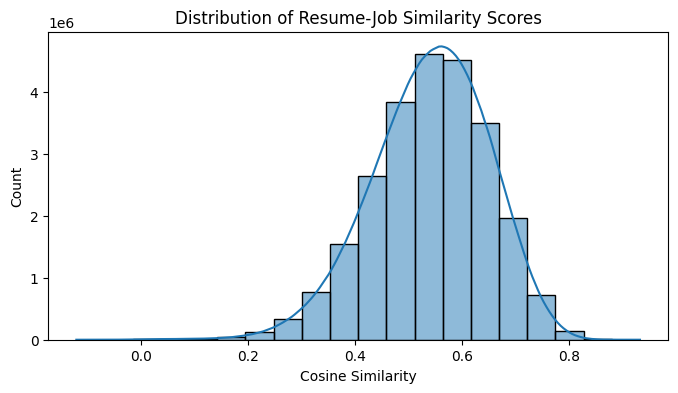

In [29]:
# Calculate all similarity scores and store them in a list
all_similarity_scores = []
for i in range(similarity_matrix.shape[0]):
    scores = similarity_matrix[i]
    all_similarity_scores.extend(scores)

# Create a DataFrame from the similarity scores
results_df = pd.DataFrame({'similarity_score': all_similarity_scores})

# Plot the distribution of similarity scores
plt.figure(figsize=(8, 4))
sns.histplot(results_df["similarity_score"], bins=20, kde=True)
plt.title("Distribution of Resume-Job Similarity Scores")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()